## Отбор признаков

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate)

In [3]:
df = pd.read_csv('datasets/gender_classification.csv')
df

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female
...,...,...,...,...,...,...,...,...
4996,1,13.6,5.1,0,0,0,0,Female
4997,1,11.9,5.4,0,0,0,0,Female
4998,1,12.9,5.7,0,0,0,0,Female
4999,1,13.2,6.2,0,0,0,0,Female


Создадим две переменные , Х содержит признаки (первые 6 столбцов), у содержит целевую переменную (7-й столбец)

In [4]:
X=df.iloc[:,:7]
y=df.iloc[:,7]
X,y

(      long_hair  forehead_width_cm  forehead_height_cm  nose_wide  nose_long  \
 0             1               11.8                 6.1          1          0   
 1             0               14.0                 5.4          0          0   
 2             0               11.8                 6.3          1          1   
 3             0               14.4                 6.1          0          1   
 4             1               13.5                 5.9          0          0   
 ...         ...                ...                 ...        ...        ...   
 4996          1               13.6                 5.1          0          0   
 4997          1               11.9                 5.4          0          0   
 4998          1               12.9                 5.7          0          0   
 4999          1               13.2                 6.2          0          0   
 5000          1               15.4                 5.4          1          1   
 
       lips_thin  distance

gender_num - данные, которые говорят о распределении пола на мужской и женский

In [7]:
df['gender_num'] = (df['gender'] == 'Male').astype(int)
df = df.drop(columns=['gender'])
df

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender_num
0,1,11.8,6.1,1,0,1,1,1
1,0,14.0,5.4,0,0,1,0,0
2,0,11.8,6.3,1,1,1,1,1
3,0,14.4,6.1,0,1,1,1,1
4,1,13.5,5.9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4996,1,13.6,5.1,0,0,0,0,0
4997,1,11.9,5.4,0,0,0,0,0
4998,1,12.9,5.7,0,0,0,0,0
4999,1,13.2,6.2,0,0,0,0,0


## Хи-квадрат

Отбор признаков на основе статистики хи-квадрат. Этот метод измеряет зависимость между категориальной зависимой переменной(у) и категориальными признаками (Х). Если X и у независимы, то взаимная информация будет равна нулю. По данным можно увидеть, что самыми взаимосвязанными переменными для gender_num(пол) явялется: nose_wide (ширина носа) и (distance_nose_to_lip_long - расстояние от носа до губ)

                       Specs        Score
3                  nose_wide  1456.149498
6  distance_nose_to_lip_long  1427.916730
5                  lips_thin  1400.647504
4                  nose_long  1362.791251
1          forehead_width_cm    51.906258
2         forehead_height_cm    18.927938
0                  long_hair     0.075583


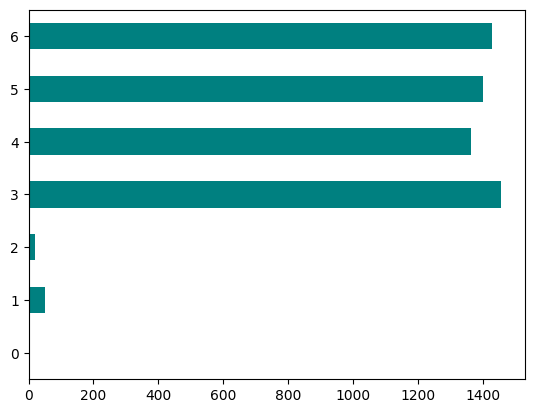

In [9]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#объединим два фрейма данных для лучшей визуализации
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #название показателей
print(featureScores.nlargest(11,'Score'))

feature_importances = pd.Series(featureScores['Score'])
feature_importances.plot(kind='barh', color='teal')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# разбиваем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('gender_num', axis=1), df['gender_num'], test_size=0.3,random_state=42)

# создаем список признаков
col_list = X_train.select_dtypes(include=['number']).columns
print(col_list)
print(X_train.shape, y_train.shape)

Index(['long_hair', 'forehead_width_cm', 'forehead_height_cm', 'nose_wide',
       'nose_long', 'lips_thin', 'distance_nose_to_lip_long'],
      dtype='object')
(3500, 7) (3500,)


In [12]:
# вычисляем AUC для модели с одним признаком,
# используя перекрестную проверку
log = LogisticRegression(solver='liblinear')
auc=cross_val_score(log, X_train, y_train, cv=5, scoring='roc_auc')

# превращаем список со значениями AUC в серию
auc_values = pd.Series(auc)
print(auc_values)

0    0.993363
1    0.993771
2    0.993192
3    0.995106
4    0.993869
dtype: float64


In [13]:
# сортируем по убыванию
auc_values = auc_values.sort_values(ascending=False)
auc_values

3    0.995106
4    0.993869
1    0.993771
0    0.993363
2    0.993192
dtype: float64

In [14]:
# формитруем датасет только из информативных показателей
x_1=X.iloc[:,auc_values.index]#3
x_1

,nose_wide,nose_long,forehead_width_cm,long_hair,forehead_height_cm
0,1,0,11.8,1,6.1
1,0,0,14.0,0,5.4
2,1,1,11.8,0,6.3
3,0,1,14.4,0,6.1
4,0,0,13.5,1,5.9
...,...,...,...,...,...
4996,0,0,13.6,1,5.1
4997,0,0,11.9,1,5.4
4998,0,0,12.9,1,5.7
4999,0,0,13.2,1,6.2


## Рекурсивное исключение признаков

Это метод рекурсивного исключения признаков (RFE) логистической регрессией для выбора наиболее значимых признаков.

In [17]:
threshold = 5 # the number of most relevant features

lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=1000)

rfe = RFE(lr, n_features_to_select=5)
rfe=rfe.fit(X, y)
# X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
selector_ind = rfe.get_support()
df_rfe = X.iloc[:, selector_ind]
print(df_rfe.columns)

Index(['forehead_height_cm', 'nose_wide', 'nose_long', 'lips_thin',
       'distance_nose_to_lip_long'],
      dtype='object')


Этот подход позволяет оценить, какие признаки вносят наибольший вклад в модель на основе выбранных метрик качества.

In [29]:
# Теперь вычислим важности признаков на основе информационного выигрыша.
# создаем экземляр класса LGBMClassifier
model_all_features = LGBMClassifier(
    random_state=42, learning_rate=0.01,
    n_estimators=300, bagging_fraction=0.5,
    feature_fraction=1, lambda_l1=10,
    importance_type='gain')
params={'verbose': -1}
model_all_features.set_params(**params)

# выполняем перекрестную проверку и сохраняем результат
# с помощью функции cross_validate()
output = cross_validate(
    model_all_features, X_train, y_train, cv=5,
    scoring='roc_auc', return_estimator=True)

# создаем список fi, в который будем сохранять
# важности признаков, и сохраняем в него важности,
# рассчитанные для каждой из моделей
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором
# будут именами наших переменных
fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx)
             for idx in range(len(fi))],
    index=X_train.columns)
# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# смотрим полученный датафрейм
fi

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
long_hair,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
forehead_width_cm,4049.483256,3056.854515,1765.777798,1658.032561,3150.856105,2736.200847
forehead_height_cm,1735.333922,1662.507959,1248.362817,1041.275487,1591.035279,1455.703093
nose_wide,31858.229099,26306.765334,23938.736908,18549.785301,47295.977016,29589.898732
nose_long,22865.340586,33115.664646,49863.045372,38423.252571,17384.516485,32330.363932
lips_thin,18888.572769,31308.363762,19981.057444,25509.834205,21248.521761,23387.269988
distance_nose_to_lip_long,72894.551389,56307.368113,54504.316649,66412.093527,60954.085170,62214.482970
